In [1]:
import theano.tensor as T
import theano
import tensorflow as tf
import numpy as np
from collections import OrderedDict
import sys
sys.path.append('../negative-sampling/')
import negsamp
import matplotlib.pylab as plt

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 4007)


In [2]:
# %matplotlib notebook
%matplotlib inline

In [7]:
data = np.load('data/iaprtc_alexfc7.npz')
D = open('data/iaprtc_dictionary.txt').read().splitlines()
train_ims = [ im.split('/')[-1] for im in open('data/iaprtc_trainlist.txt').read().splitlines() ]
xTr = data['xTr'].T
yTr = data['yTr'].T
xTe = data['xTe'].T
yTe = data['yTe'].T

test_ims_full = [ im for im in open('data/iaprtc_testlist.txt').read().splitlines() ]
train_ims_full = [ im for im in open('data/iaprtc_trainlist.txt').read().splitlines() ]

## Functional definition
### This part is unnecessarily complicated if we're just doing pseudoinverse. (Tensorflow makes the code explode)

In [8]:
def normfeats( X ):
    return ( X.T / np.linalg.norm( X, axis = 1 ) ).T
    
def buildcov( X ):
    if type(X)==np.ndarray:
        return X.T.dot(X)
    return tf.matmul(tf.transpose(X),X)

# Pseudoinverse
def invertcov( X ):
    if type(X)==np.ndarray:
        return np.linalg.inv( buildcov(X) )
    return tf.matrix_inverse( buildcov(X) )

def inverseproblem( X, Ytruth ):
    if type(X)==np.ndarray:
        return Ytruth.T.dot(X).dot( invertcov(X))
    return tf.matmul( tf.transpose( Ytruth ), tf.matmul( X, invertcov(X) ))

## Training
### Really, just apply W matrix.

In [9]:
if False:
    sess = tf.InteractiveSession()

    # Initialize the variables
    tf.initialize_all_variables().run()
    # Get a batch for training
    thearray = list( xrange(len(yTr)) )
    thearray.remove( 2868 )
    imbatch, wordbatch = get_training_batch(thearray)
    Wout = sess.run( [W], feed_dict={X:xTr, Ytruth: np.float32(yTr) } )
    
    sess.close()
    
else:
    
    Xnorm = normfeats( xTr ).astype(np.float32)
    Ytr = yTr.astype(np.float32)
    Wtr = inverseproblem(Xnorm, yTr)

In [10]:
predictor = Wtr.dot( normfeats(xTe).T.astype(np.float32) ).T

## Visualization

Looking at the 196th image: images/04/4239.jpg
Predicted: woman, front, man, window, tee-shirt, square, street, cap, jacket, wood
Truth:     glass, jumper, man, shelf, shirt, woman


<Container object of 3 artists>

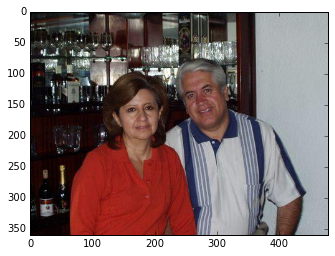

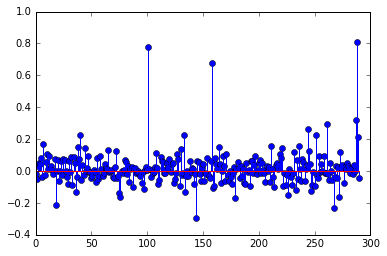

In [33]:
# Randomly select an image
i=np.random.randint(0, yTe.shape[1])

# Run example
imname='images/'+test_ims_full[i]+'.jpg';
print "Looking at the "+str(i)+"th image: "+imname
im=plt.imread(imname)

# Prediction
ypwords = [D[j] for j in predictor[i].argsort()[::-1] [ 0:(predictor[i]>0.2).sum() ] ]
# Truth
ytwords = [D[j] for j in np.where(yTe[i] > 0.5)[0] ]

plt.imshow(im)
print 'Predicted: '+ ', '.join(ypwords)
print 'Truth:     '+ ', '.join(ytwords)

plt.figure()
plt.stem( predictor[i] )